<a href="https://colab.research.google.com/github/Existanze54/sirius-neural-networks-2024/blob/main/Lections/03L_Convolutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Сверточные нейронные сети

Сегодня мы рассмотрим тип нейронных сетей, с которыми обычно связывают первые state-of-the-art успехи нейронных сетей - сверточные нейронные сети.



## ImageNet

Конкретно, сверточные нейорнные сети (AlexNet) уменьшили ошибку классификации изображений в конкурсе ImageNet в полтора раза.

После 2012 года в этом конкурсе всегда используются нейронные сети и методы, основанные на них


<img src ="https://data.bioml.ru/htdocs/courses/bioml/neural_networks/cnn/img/imagenet_qualities.png"  width="700">

## Нарушение связей между соседними пикселями

Чтобы разобраться в причинах успеха, давайте сначала разберемся, в чем состоит проблема работы с изображениями обычными методами классического ML и многослойными персептронами?

Для того, чтобы работать с изображением обычными методами, при этом без дополнительной предобработки, а кормить изображение as is - его надо растянуть в одномерный вектор.

В результате такого преобразования теряется связь между соседними пикселями.


<img src ="https://data.bioml.ru/htdocs/courses/bioml/neural_networks/cnn/img/ravel_data.png" width="400px">

Точнее - связь остается, но она становится неявной. Модель нужно самой понять, что 0, 10 и 20 точки в одномерном векторе представляют собой пиксели, которые на самом деле лежат рядом, а 4,5,6 - нет.








Модели нужно самой догадаться, что ухо может быть расположено в любой части изображения и потому к определенным частям вектора должны быть применены одни и те же веса.

<img src ="https://data.bioml.ru/htdocs/courses/bioml/neural_networks/cnn/img/cat_augments.png"  width="700">

Обычно модель не в состоянии этого понять, особенно если выборка "мала".

А малость выборки отчасти определяется и числом весов, которые надо учить.
Пусть для нейронных сетей число реально используемых весов и "сложность" модели неочевидно коррелирует с числом весов в сети, все равно, подход, основанный на обычной многослойной нейросети приведет еще и к следующему:





In [ ]:
import torch
import torch.nn as nn


class SimpleImageClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(nn.Linear(3072, 500),
                                   nn.ReLU(),
                                   nn.Linear(500, 100),
                                   nn.ReLU(),
                                   nn.Linear(100, 10))

    def forward(self, x):
        return self.model(x)


def parameter_count(model):
    pars = 0
    for tag, p  in model.named_parameters():
        pars += torch.prod(torch.tensor(p.shape))
    return pars



In [ ]:
parameter_count(SimpleImageClassifier())

tensor(1587610)

Мы сделали всего лишь трехслойную нейронную сеть, а у нас уже полтора миллиона параметров.

А если изображение будет больше? А уверены ли мы, что нам хватит трех слоев?

При этом, еще раз, заметим - бОльшая часть из этих параметров вырождены - нейросеть должна одинаково искать глаз кошки на всей фотографии, потому нейроны, отвечающие за поиск этого глаза будут иметь похожие веса.

В случае классических методов проблема аналогична - большое число входных признаков, которые еще сильно друг с другом коррелированы, при этом каждый в отдельности говорит нам очень мало информации.
Деревья решений в таком случае в принципе работать не будут - им просто не хватит информации, чтобы правильно разделять классы.

## Интуиция

До этого мы пытались заставить нашу нейросеть на основе вектора входов выучить какую-то функцию

<img src="https://data.bioml.ru/htdocs/courses/bioml/neural_networks/cnn/img/conv_transition_9toF.png" width="500px">

Теперь мы хотим сделать хитрее - допустим, наши входы локально связаны. Давайте мы сделаем нейросеть из двух частей.

Первая часть (A) будет локальной - она будет для каждого набора рядом лежащих входов предсказывать какое-то значение, например, кодируют ли эти входы ухо кошки.

<img src="https://data.bioml.ru/htdocs/courses/bioml/neural_networks/cnn/img/conv_transition_unit_single.png" width="300px">



Будем для каждой локальной области делать предсказание нашей маленькой сетью

<img src="https://data.bioml.ru/htdocs/courses/bioml/neural_networks/cnn/img/conv_transition_units_many.png" width="400px">


А далее уже на основе предсказаний этой нейросети, наша полносвязная сеть F будет делать финальное предсказание.

<img src="https://data.bioml.ru/htdocs/courses/bioml/neural_networks/cnn/img/conv_transition_units_many_toF.png" width="500px">

При желании мы можем даже на предсказания локальной сети A, "натравить" локальную сеть B, которая будет на основе простых преддказаний A (например, A предсказывает наличие линий на изображении), предсказывать более сложные паттерны (то же ухо кошки)

<img src="https://data.bioml.ru/htdocs/courses/bioml/neural_networks/cnn/img/conv_transition_units_many_secondconv_toF.png" width="500px">

Заметьте, что у нас получается иерархическая структура - сеть A выделяет простой локальный признак, наличие линии. Сеть опять же, пользуясь тем, что мы сохранили взаиморасположение предсказаний сети A, предсказывает что-то более сложное. А затем уже на предсказание этого сложного по всему изображению смотрит сеть F, которая аггрегирует иннформацию со всего изображения

## Свертка

И тут к нам на помощь приходит то, как решали некоторые задачи компьютерного зрения до появления нейронных сетей.




### Фильтр Собеля

На заре компьютерного зрения люди придумывали различные операции, которые будут находить важные элементы на изображении. К примеру, границы. Примером подобной операции является фильтр Собеля.

<img src ="https://data.bioml.ru/htdocs/courses/bioml/neural_networks/cnn/img/sobel_wikipedia.png" width="300">


### Интуиция

Как это работает?

Для того, чтобы понять это, нам придется ввести понятие свертки.

Представим, что мы ищем некий шаблон в одномерном сигнале. Например - квадратик.
Как бы нам проверить весь сигнал на наличие этого шаблона в каждой позиции?

Нарисуем, как выглядит наш квадрат, и будем его прикладывать в каждой точке сигнала и считать, насколько совпал сигнал и наш квадрат (например, по доли площади)

Чем больше совпадение - тем больше реакция.

<img src ="https://data.bioml.ru/htdocs/courses/bioml/neural_networks/cnn/img/convolution_continuous.gif" width="900">

Таким образом на основе одномерного сигнала и некоего паттерна мы получаем новый одномерный сигнал, который содержит информацию о силе проявления данного паттерна вдоль одномерного сигнала.




### Одномерная свертка

Как записать это в математическом виде?

На самом деле - очень просто.

Одномерный сигнал - это просто массив из чисел.

Наш паттерн, схожесть с которым мы меряем - тоже массив, называется **ядром** свертки

<img src="https://data.bioml.ru/htdocs/courses/bioml/neural_networks/cnn/img/conv_1d_simple.png" width="800">




#### Производная

На самом деле свертка не обязательно соответствует какому-то паттерну. Она может и считать какую-то локальную операцию.

Например, посчитать приближенное значение производной в каждой точке сигнала.

$$f'(x) = \dfrac {f(x + \Delta) - f(x - \Delta) } {2\Delta} $$



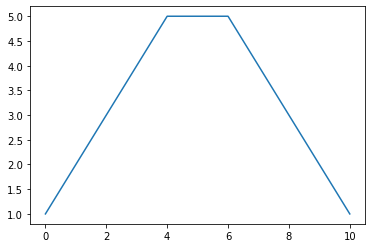

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
signal = np.array([1,2,3,4,5,5,5,4,3,2,1])
plt.plot(signal)

In [ ]:
deriv = np.array([-1, 0, 1]) / 2

res = np.zeros(signal.shape[0] - 2)
for i in range(0, signal.shape[0] - 2):
    res[i] = np.sum(deriv * signal[i:i+3])

print(res)

[ 1.   1.   1.   0.5  0.  -0.5 -1.  -1.  -1. ]


Аналогично можно написать ядро, считающее вторую производную

$$f''(x) \approx \dfrac {f(x + \Delta) - 2 f(x) +  f(x - \Delta) } {\Delta ^ 2 } $$


In [ ]:
import numpy as np
x = np.linspace(-5, 5, num=100)
signal = x ** 4
afsecond = 12 * x ** 2

deriv2 = np.array([1,-2, 1])  / (x[1] - x[0]) ** 2



res = np.zeros(signal.shape[0] - 2)
for i in range(0, signal.shape[0] - 2):
    res[i] = np.sum(deriv2 * signal[i:i+3])



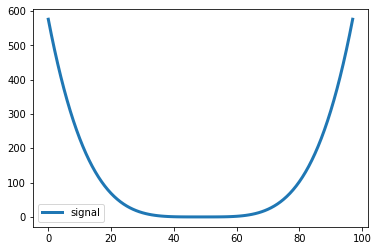

In [ ]:
plt.plot(signal[1:-1], label="signal", linewidth=3)
plt.legend()

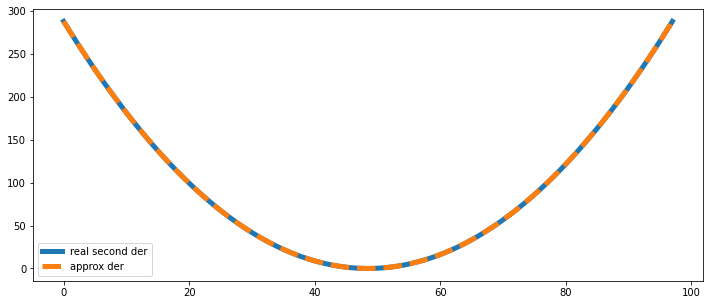

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.plot(afsecond[1:-1], label="real second der", linewidth=5)
plt.plot(res, "--", label="approx der", linewidth=5)
plt.legend()

Видим, что вид аналитического решения и того, что мы посчитали приблизительно, практически совпадает

### 2D случай

В случае черно-белых двумерных изображений информация у нас хранится в двух измерениях.

Потому и свертки должны быть двумерные.

Остальное не меняется.

![conv_2d_anim](https://data.bioml.ru/htdocs/courses/bioml/neural_networks/cnn/img/conv_2d_anim.gif)


Вопрос на засыпку - что считает конволюция на картинке?



### Примеры

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import skimage

In [ ]:
def conv(x, filter):
    K = filter.shape[0]
    M, N = x.shape
    M_, N_ = 1 + M - K, 1 + N  - K
    matrix = np.zeros((M_, N_))
    for i in range(0, M - K + 1, 1):
        for j in range(0, N - K + 1, 1):
            matrix[i, j] = np.sum(x[i:i+K, j:j+K] * filter)
    return matrix

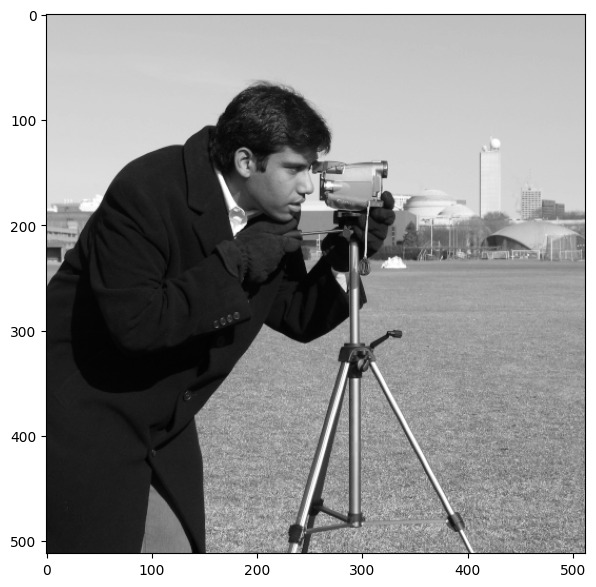

In [ ]:
plt.figure(figsize=(7, 7))
camera = skimage.data.camera()
plt.imshow(camera, cmap='gray', vmin=0, vmax=255)

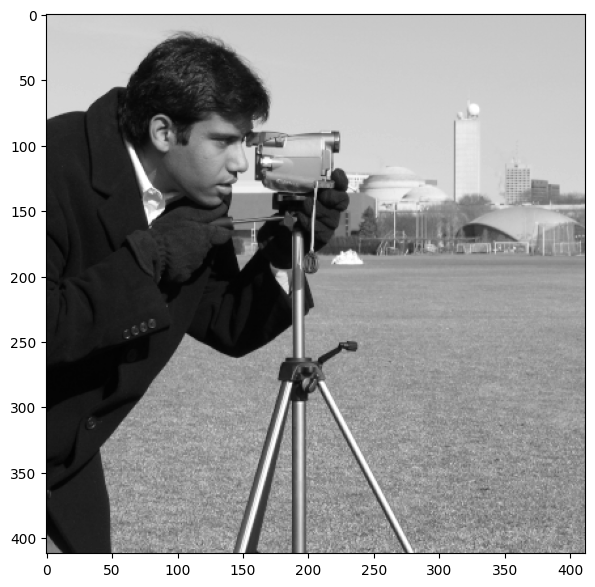

In [ ]:
plt.figure(figsize=(7, 7))
shift_filt = np.zeros((101, 101))
shift_filt[50, -1] = 1
camera_shift = conv(camera, shift_filt)
plt.imshow(camera_shift, cmap='gray', vmin=0, vmax=255)

Можно сделать размывающий фильтр - заменяем каждый пиксель средним в окне вокруг него

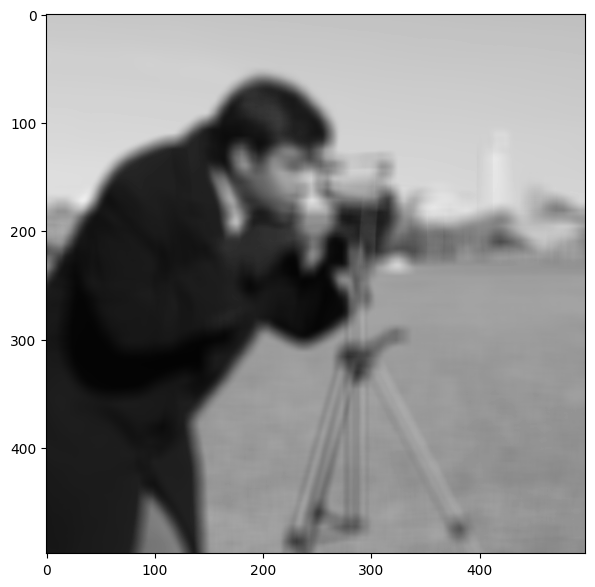

In [ ]:
plt.figure(figsize=(7,7))
blur_filt = np.ones((15, 15)) / (15 ** 2)
camera_blur = conv(camera, blur_filt)
plt.imshow(camera_blur, cmap='gray', vmin=0, vmax=255)

Или сделать изображение более резким

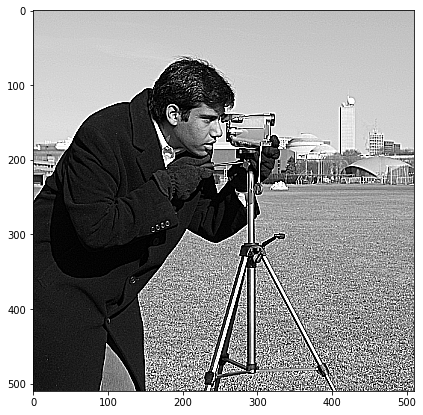

In [ ]:
plt.figure(figsize=(7,7))
sharp_filt = np.array([[-1, -1, -1],
                       [-1,  9, -1],
                       [-1, -1, -1]])
camera_sharp = conv(camera, sharp_filt)
plt.imshow(camera_sharp, cmap='gray', vmin=0, vmax=255)

## Каналы

До этого мы предполагали, что наш сигнал имеет только одно измерение - время.
А картинка - черно-белая.

Но что делать, если измерение не одно. Самый простой пример - трехцветное изображение

Логично, что мы хотим иметь возможность делать искомый паттерн тоже трехцветным - то есть теперь у нас фильтр конволюции тоже имеет каналы.

И что и как с этим делать?

Сначала берем и на каждый канал исходного изображения применяем соответствующий канал фильтра

![conv_colored](https://data.bioml.ru/htdocs/courses/bioml/neural_networks/cnn/img/conv_colored_1.gif)

И затем складываем полученные отклики

![conv_colored](https://data.bioml.ru/htdocs/courses/bioml/neural_networks/cnn/img/conv_colored_2.gif)


Сейчас нам это не принципиально, но в случае нейросетей мы можем добавлять к резуультату еще некую константу (bias) - чтобы иметь возможность смещать тот же сигнал в ту или иную область функции активации

![conv_colored](https://data.bioml.ru/htdocs/courses/bioml/neural_networks/cnn/img/conv_colored_3.gif)

Заметим, что при этом из трехканального изображения мы получили **одноканальный сигнал**

Как это выглядит на самом деле:

![conv_colored_channels](https://data.bioml.ru/htdocs/courses/bioml/neural_networks/cnn/img/conv_colored_channels_2d.png)

Источник: _Prince, 2023_

### RGB to grayscale


$$Grayscale  = 0.299R + 0.587G + 0.114B$$




Можем даже эту операцию при желании записать в виде свертки

In [ ]:
def conv(x, filter):
    K = filter.shape[0]
    M, N, _ = x.shape
    M_, N_ = 1 + M - K, 1 + N - K
    matrix = np.zeros((M_, N_))
    for i in range(0, M - K + 1, 1):
        for j in range(0, N - K + 1, 1):
            matrix[i, j] = np.sum(x[i:i+K, j:j+K] * filter)
    return matrix

In [ ]:
coffee = skimage.data.coffee()

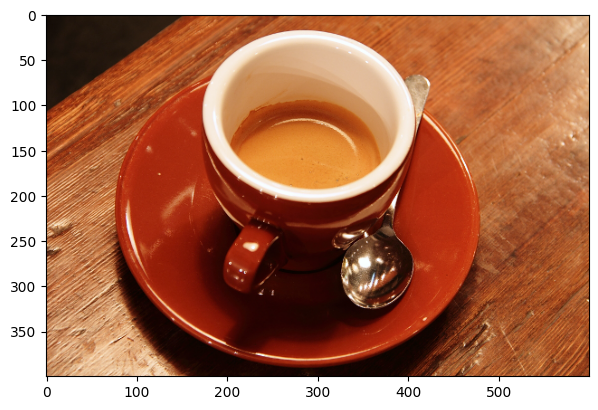

In [ ]:
plt.figure(figsize=(7,7))
plt.imshow(coffee, vmin=0, vmax=255)

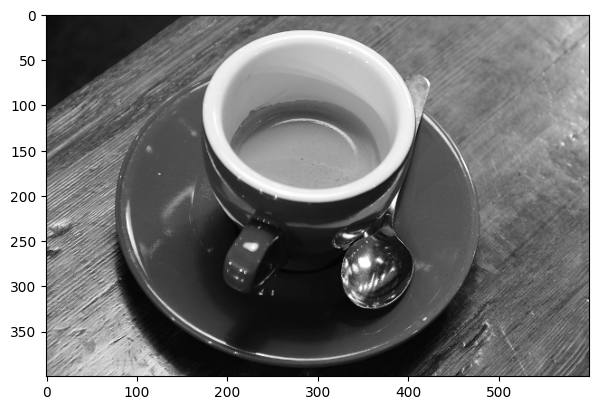

In [ ]:
plt.figure(figsize=(7,7))
greyscale_filt = np.ones((1, 1, 3), dtype=np.float64)
greyscale_filt[:, :, 0] = 0.299
greyscale_filt[:, :, 1] = 0.587
greyscale_filt[:, :, 2] = 0.114

coffee_sharp = conv(coffee, greyscale_filt)
plt.imshow(coffee_sharp, cmap='gray', vmin=0, vmax=255)

Подобные фильтры до сих пор используются почти во всех редакторах изображений.

### Границы

Можно посмотреть все границы

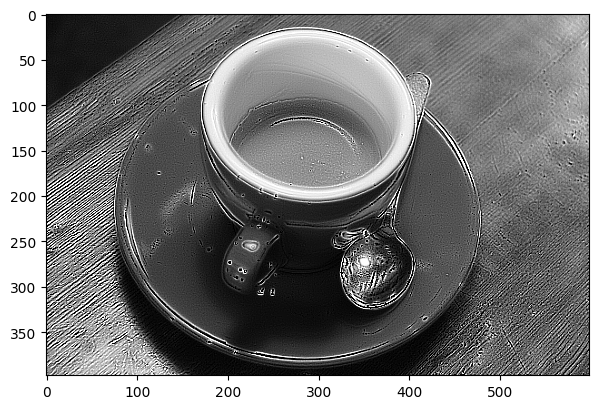

In [ ]:
plt.figure(figsize=(7,7))

onec = np.array([[1,  1,  1],
                 [1, -7,  1],
                 [1,  1,  1]])[:, :, None]
edge_filt = np.concatenate([onec, onec, onec], axis=2) / 3

coffee_edge= conv(coffee, edge_filt)
plt.imshow(coffee_edge, cmap='gray', vmin=0, vmax=255)

### Поиск паттерна

Можем спрятать на изображении какой-то паттерн. Например - желтый квадрат 50 на 50 пикселей

In [ ]:
coffee.shape

(400, 600, 3)

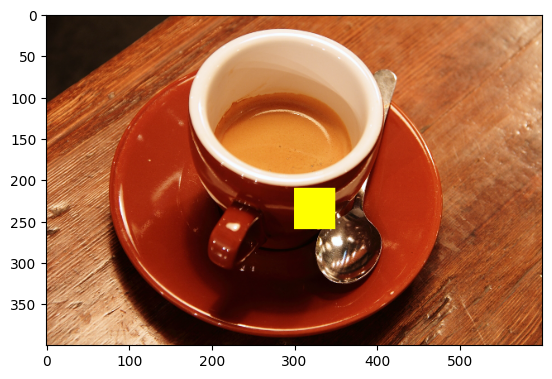

In [ ]:
coffee_s = skimage.data.coffee().copy()
w = 50
coffee_s[210:210+w, 300:300+w, 0] = 255
coffee_s[210:210+w, 300:300+w, 1] = 255
coffee_s[210:210+w, 300:300+w, 2] = 0
plt.imshow(coffee_s, vmin=0, vmax=255)

И добавим несколько ложных следов



In [ ]:
coffee_s[310:310+w, 200:200+w, 0] = 255
coffee_s[310:310+w, 200:200+w, 1] = 0
coffee_s[310:310+w, 200:200+w, 2] = 255

In [ ]:
coffee_s[110:110+w, 100:100+w, 0] = 128
coffee_s[110:110+w, 100:100+w, 1] = 128
coffee_s[110:110+w, 100:100+w, 2] = 128

In [ ]:
coffee_s[110:110+w, 300:300+w, 0] = 0
coffee_s[110:110+w, 300:300+w, 1] = 128
coffee_s[110:110+w, 300:300+w, 2] = 128

In [ ]:
np.random.seed(777)
i = np.random.choice(400, 1000)
j = np.random.choice(600, 1000)
coffee_s[i, j, 0] = 255
coffee_s[i, j, 1] = 255
coffee_s[i, j, 2] = 0

In [ ]:
i = np.random.choice(400 - 5, 1000)
j = np.random.choice(600 - 5, 1000)

for si in range(0, 5):
    for sj in range(0, 5):
        coffee_s[i + si, j + sj, 0] = 255
        coffee_s[i + si, j + sj, 1] = 255
        coffee_s[i + si, j + sj, 2] = 0

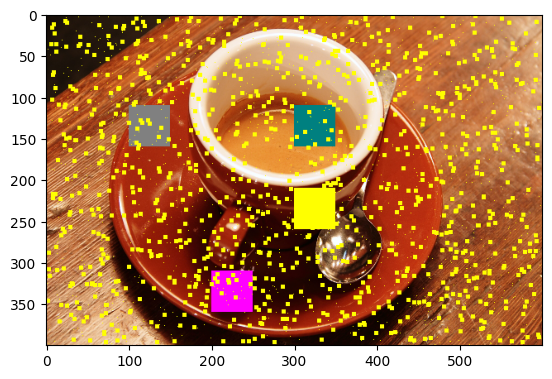

In [ ]:
plt.imshow(coffee_s, vmin=0, vmax=255)
plt.show()

Напишем фильтр, который будет искать наш квадратик

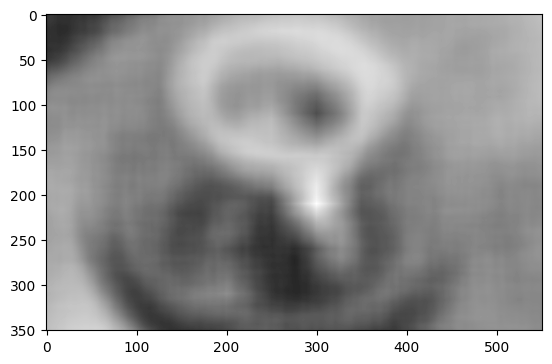

In [ ]:
yellow_square = np.stack([np.ones((w, w)), np.ones((w, w)), np.zeros((w, w))], axis=2) / (w * w * 2)

coffee_square = conv(coffee_s, yellow_square)
plt.imshow(coffee_square, cmap='gray', vmin=0, vmax=255)
plt.show()

Видим зону больших значений - белые пиксели - в основном сосредоточенные в районе нашего квадратика

In [ ]:
np.unravel_index(coffee_square.argmax(), coffee_square.shape)

(210, 300)

Действительно, максимум лежит именно там, где мы загадали

Если добавить несколько квадратов - то будет несколько областей с максимумом

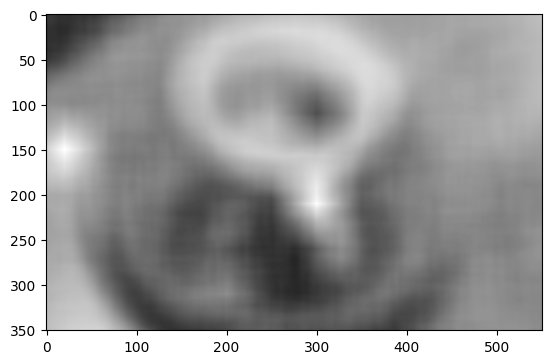

In [ ]:
coffee_s[150:150+w, 20:20+w, 0] = 255
coffee_s[150:150+w, 20:20+w, 1] = 255
coffee_s[150:150+w, 20:20+w, 2] = 0

coffee_square = conv(coffee_s, yellow_square)
plt.imshow(coffee_square, cmap='gray', vmin=0, vmax=255)

Далее мы можем сказать, что мы допускаем отклонение от идеального квадратика на, например, 5, все остальное - шум

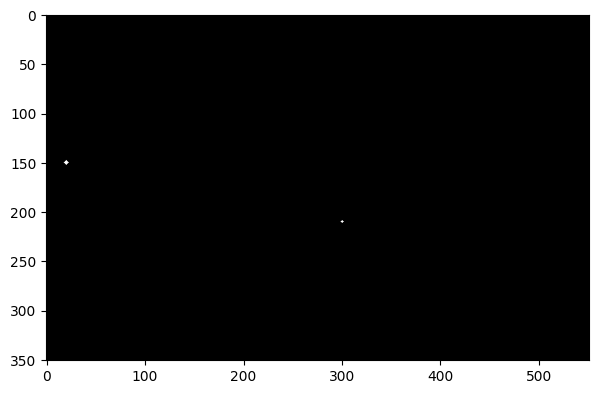

In [ ]:
coffee_square[coffee_square < (255 - 5)] = 0
plt.figure(figsize=(7,7))
plt.imshow(coffee_square, cmap='gray', vmin=0, vmax=255)

Фактически - мы применили функцию активации - ReLU (с порогом не в нуле)

<img src="https://data.bioml.ru/htdocs/courses/bioml/neural_networks/pytorch/img/relu.png">

Более того, при желании можно применить обычный ReLU, предварительно вычтя из сигнала 250. То есть, кроме фильтра, вводим дополнительный вес - **bias**.

В итоге мы получили "картинку" - feature map, которая содержит информацию о том, где на исходной картинке лежат квадратики.

### Поиск составного паттерна

А что если нам нужен не простой паттерн, а, включающий несколько подпаттернов?

Наш фильтр выше, кстати, не идеален - он будет реагировать как на желтый квадрат, так и на белый. Можно поправить это руками (добавив вычитание на слой ядра, работающий с синим цветом). А можно сделать немного иначе.



Мы хотим находить только красные квадраты.

Мы не хотим находить желтые квадраты и розовые (которые тоже содержат красный цвет).
Для простоты задачи мы не штрафуем (и не награждаем себя) за реакцию на белые квадраты.

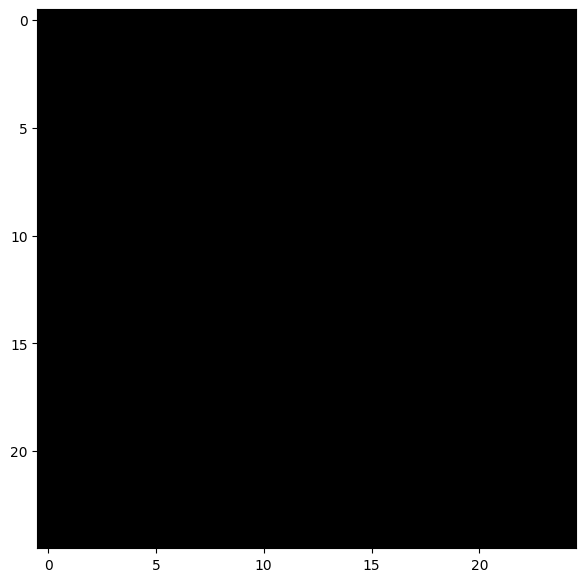

In [ ]:
blank = np.zeros((25, 25, 3), dtype=np.uint8)
plt.figure(figsize=(7, 7))
plt.imshow(blank)

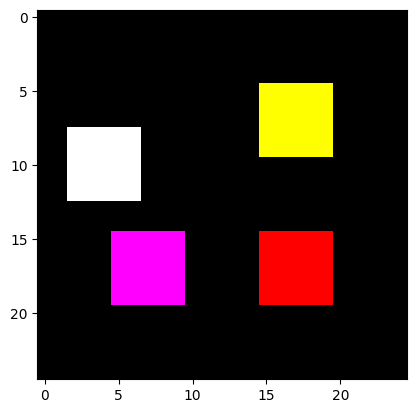

In [ ]:
blank = np.zeros((25, 25, 3), dtype=np.uint8)

x = 15
y = 15
w = 5

blank[x:x+w, y:y+w, 0] = 255
blank[x:x+w, y:y+w, 1] = 0
blank[x:x+w, y:y+w, 2] = 0

blank[x-10:x+w-10, y:y+w, 0] = 255
blank[x-10:x+w-10, y:y+w, 1] = 255
blank[x-10:x+w-10, y:y+w, 2] = 0


blank[x:x+w, y-10:y-10+w, 0] = 255
blank[x:x+w, y-10:y-10+w, 1] = 0
blank[x:x+w, y-10:y-10+w, 2] = 255


blank[x-7:x-7+w, y-13:y-13+w, 0] = 255
blank[x-7:x-7+w, y-13:y-13+w, 1] = 255
blank[x-7:x-7+w, y-13:y-13+w, 2] = 255

plt.imshow(blank,  vmin=0, vmax=255)

Решим эту задачу, сведя к предыдущей.

Сначала напишем свертки, которые детектят красные, желтые и розовые квадраты


Сделаем по свертке на каждый тип квадрата

In [ ]:
red_square = np.stack([np.ones( (w,w)), np.zeros( (w,w)), np.zeros((w,w))], axis=2) / (w * w )
yellow_square = np.stack([np.ones( (w,w)), np.ones( (w,w)), np.zeros((w,w))], axis=2) / (w * w * 2)
pink_square = np.stack([np.ones( (w,w)), np.zeros( (w,w)), np.ones((w,w))], axis=2) / (w * w * 2)

blank_y_square= conv(blank, yellow_square)
blank_r_square= conv(blank, red_square)
blank_p_square= conv(blank, pink_square)

Обрежем шум, скажем, все места, где сигнал меньше 250

In [ ]:
blank_y_square[blank_y_square < 250] = 0
blank_r_square[blank_r_square < 250] = 0
blank_p_square[blank_p_square < 250] = 0

А теперь объединим их в единую матрицу, трактуя их как каналы нового изображения!

Активации желтого фильтра будут трактоваться как красный цвет, красного фильтра - как зеленый, а белого - как синий




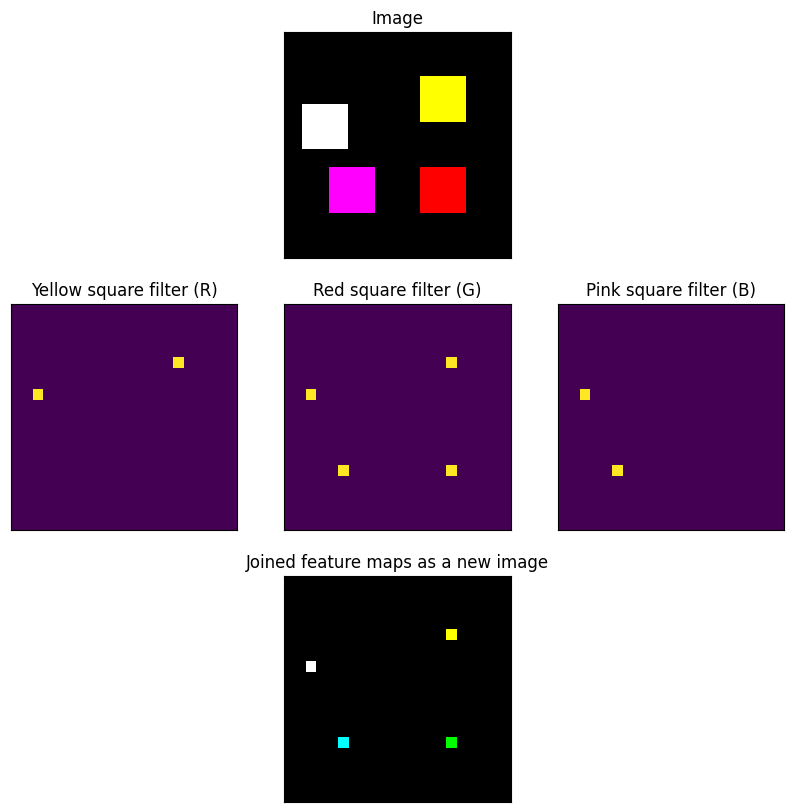

In [ ]:
simple_features = np.stack([blank_y_square, blank_r_square, blank_p_square], axis=2)

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10,10))

ax[0, 1].set_title("Image")
ax[0, 1].imshow(blank,  vmin=0, vmax=255)
ax[0, 1].set_xticks([])
ax[0, 1].set_yticks([])
ax[0, 0].axis('off')
ax[0, 2].axis('off')


ax[1, 0].set_title("Yellow square filter (R)")
ax[1, 0].imshow(blank_y_square)
ax[1, 0].set_xticks([])
ax[1, 0].set_yticks([])
ax[1, 1].set_title("Red square filter (G)")
ax[1, 1].imshow(blank_r_square)
ax[1, 1].set_xticks([])
ax[1, 1].set_yticks([])
ax[1, 2].set_title("Pink square filter (B)")
ax[1, 2].imshow(blank_p_square)
ax[1, 2].set_xticks([])
ax[1, 2].set_yticks([])

ax[2, 1].set_title("Joined feature maps as a new image")
ax[2, 1].imshow(np.asarray(simple_features, dtype=np.int64))
ax[2, 1].set_xticks([])
ax[2, 1].set_yticks([])
ax[2, 0].axis('off')
ax[2, 2].axis('off')
plt.subplots_adjust()
plt.show()

Видно, что красный квадрат распознался только красным фильтром (зеленый квадратик), белый - всеми (белый квадратик), желтый - красным и желтым (желтый квадратик), а фиолетовый - фиолетовым и желтым (голубой квадратик = зеленый + синий цвета)

А теперь трактуем эту матрицу как новое изображение. И напишем для нее фильтр. Фильтр будет выглядеть просто - мы хотим занулять те позиции, где встретился и красный квадрат, и желтый или фиолетовый.

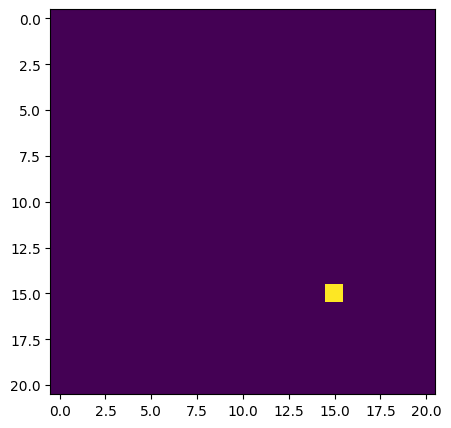

In [ ]:
feature_filter = np.zeros((1, 1, 3))
feature_filter[:, :, 0] = -2 # penalty for yellow
feature_filter[:, :, 1] = 1
feature_filter[:, :, 2] = -2 # penalty for pink


final_img = conv(simple_features, feature_filter)

final_img[final_img < 250] = 0

plt.figure(figsize=(5,5))
plt.imshow(np.asarray(final_img , dtype=np.int64),  vmin=0, vmax=255)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecat

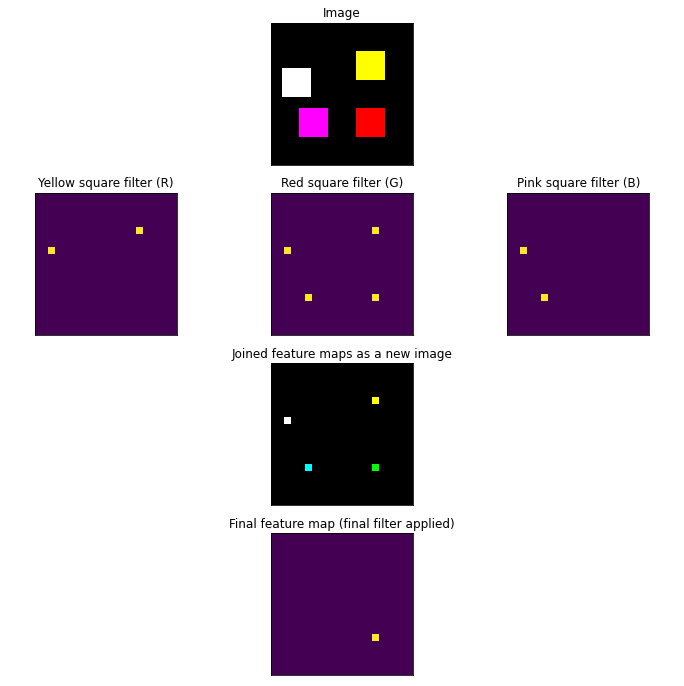

In [ ]:
simple_features = np.stack([blank_y_square, blank_r_square, blank_p_square], axis=2)

fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(12, 12))

ax[0, 1].set_title("Image")
ax[0, 1].imshow(blank,  vmin=0, vmax=255)
ax[0, 1].set_xticks([])
ax[0, 1].set_yticks([])
ax[0, 0].axis('off')
ax[0, 2].axis('off')


ax[1, 0].set_title("Yellow square filter (R)")
ax[1, 0].imshow(blank_y_square)
ax[1, 0].set_xticks([])
ax[1, 0].set_yticks([])
ax[1, 1].set_title("Red square filter (G)")
ax[1, 1].imshow(blank_r_square)
ax[1, 1].set_xticks([])
ax[1, 1].set_yticks([])
ax[1, 2].set_title("Pink square filter (B)")
ax[1, 2].imshow(blank_p_square)
ax[1, 2].set_xticks([])
ax[1, 2].set_yticks([])

ax[2, 1].set_title("Joined feature maps as a new image")
ax[2, 1].imshow(np.asarray(simple_features, dtype=np.int))
ax[2, 1].set_xticks([])
ax[2, 1].set_yticks([])
ax[2, 0].axis('off')
ax[2, 2].axis('off')

ax[3, 1].set_title("Final feature map (final filter applied)")
ax[3, 1].imshow(np.asarray(final_img , dtype=np.int),  vmin=0, vmax=255)
ax[3, 1].set_xticks([])
ax[3, 1].set_yticks([])
ax[3, 0].axis('off')
ax[3, 2].axis('off')

plt.subplots_adjust()
plt.show()

Видим, что теперь мощный сигнал дает только красный квадрат

In [ ]:
np.unravel_index(final_img.argmax(), final_img.shape)

(15, 15)

В данном случае, однако, можно было обойтись и без конволюции - просто вычесть одни feature map из других.

Но что, если нам, например, паттерн, состоящий из красного  квадрата и желтого, отстоящих друг от друга на расстоянии 50 по вертикали?

Тут тоже можно придумать фильтр, который будет на основе более простых признаков, делать более сложные - вплоть до решения задачи.

В этом и заключается смысл конволюционных сетей, которые мы рассмотрим далее - сначала выделить на изображении простые признаки, потом объединить их в более сложные и т.д

## Сверточный слой

### Обучаемые фильтры

Первое отличие от того, что мы разобрали - веса фильтров мы будем учить, а не подбирать руками.

Фактически - мы будем учить кучу маленьких нейросеток, которые будут выделять нам необходимые признаки, как обсуждали ранее

<img src="https://data.bioml.ru/htdocs/courses/bioml/neural_networks/cnn/img/conv_transition_unit_single.png" width="300px">


### Множество фильтров

Каждый слой нейросетки будет представлять из себя _набор_ таких фильтров. Каждый будет искать свой паттерн, потому на выходе мы будем получать не один слой, содержащий информацию о вхождениях одного паттерна, а много слоев, каждый из которых содержит информацию о своем параметре.

<img src ="https://data.bioml.ru/htdocs/courses/bioml/neural_networks/cnn/img/many_conv_filters.png" width="700">

Источник: IndoML

### Bias

По умолчанию к результату свертки добавляется число - `bias`.

<img src="https://data.bioml.ru/htdocs/courses/bioml/neural_networks/cnn/img/conv_layer_decomp.png" width="900px">

В некоторых случаях `bias` можно занулять, так же как и в линейном слое. Например, если используются конволюции вместе с `BatchNorm`, который мы разберем в следующих лекциях.

### Класс `nn.Conv`

Как будет выглядеть сверточный слой в pytorch - просто объект класса `nn.Conv2d` (либо `nn.Conv1d` / `nn.Conv3d`, в зависимости от вашей задачи).

In [ ]:
import torch.nn as nn

In [ ]:
?nn.Conv2d

Теперь надо понять, что значат все эти страшные аргументе в конструкторе слоя.

Разберем не все, а основные параметры.

1. `in_channels` - сколько каналов (feature_map) во входном изображении.
2. `out_channels` - сколько feature map должен слой подсчитывать. Фактически - сколько признаков слой выделяет во входном изображении
3. `kernel_size` - размер ядра свертки.

Это обязательные аргументы. В принципе, задав их, можно получить сверточный слой.


In [ ]:
nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)

Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))

Но есть еще пара аргументов, которые нам надо разобрать.

### Stride

До этого у нас ядро конволюции шло по всему изображению, каждый раз сдвигаясь на 1 шаг.

<img src ="https://data.bioml.ru/htdocs/courses/bioml/neural_networks/cnn/img/param_stride_1_anim.gif" width="700">





Можно этот шаг сделать больше.

<img src ="https://data.bioml.ru/htdocs/courses/bioml/neural_networks/cnn/img/param_stride_2_anim.gif" width="700">


Зачем? Это позволяет нам эффективнее  уменьшать изначальный размер изображения при прохождении через свертки.

Почему так можно делать - часто соседний ячейки feature map с stride=1 будут содержать сильно похожую информацию - можем часть такой feature map "выкинуть"

In [ ]:
nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2)

Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2))

### Padding

Все это время мы умолчивали о том, что свертки по-умолчанию меняют размер изображения. Обычно мы не хотим такого поведения, иногда нам не хочется, чтобы размер изображения менялся после применения свертки

Есть несколько возможных вариантов поведения в данной ситуации и они решаются параметром **padding**.







Суть любого padding заключается в том, что мы расширяем изображение за счет значений, добавляемых по краям.

Можно добавлять разные значения, это зависит от задачи, но обычно достаточно просто добавить 0.

Как добавить 0 столько, чтобы размер изображения не менялся? Можно использовать значение параметра `padding = "same"`

Для случая, когда `stride=1`, а `ks=3`, достаточно добавить по одному ряду 0 с каждой стороны изображения.

<img src ="https://data.bioml.ru/htdocs/courses/bioml/neural_networks/cnn/img/param_padding_anim.gif" width="700">

In [ ]:
nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding="same")

Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)

Аналогично можно задавать любой `padding`, чтобы добиться размерности изображения, которая вам нужна. Но чаще всего либо `padding` не делают, либо делают `"same"`

Понятно, что можно комбинировать stride и padding. Например, здесь `padding=1`, `stride=2`.

<img src ="https://data.bioml.ru/htdocs/courses/bioml/neural_networks/cnn/img/param-h_stride_1_padding_2.gif">


### Dilation (Atrous convolutions)



Также в биологии может быть интересен параметр `dilation`, который позволяет использовать ядро с пропусками между ячейками.

<img src ="https://data.bioml.ru/htdocs/courses/bioml/neural_networks/cnn/img/param-h_dilation.gif">

Это позволяет игнорировать рядом стоящие сигналы (так как они, скорее всего, cкоррелированы) и, не увеличивая число параметров нейросети, осматривать одним шагом конволюции большую область (receptive field, разбирается ниже).

### Пример простой сверточной сети

<img src="https://data.bioml.ru/htdocs/courses/bioml/neural_networks/cnn/img/example_simple_cnn.png" width="800px">

### Рецептивное поле
#### (или как понять, что конволюций _недостаточно_)

Есть еще один вопрос - как понять, что в нашей архитектуре достаточно конволюций?

Вопрос не имеет точного ответа - но главным образом это  зависит от размера паттерна, который мы будем искать

Каждое применения ядра концолюционного слоя видит лишь малую часть переданного ему входа.

<img src ="https://data.bioml.ru/htdocs/courses/bioml/neural_networks/cnn/img/receptive_field_2d.png" width="900">

Например, два последовательных конвоюционных слоя с ядром 3x3 породят feature map, каждое значение в которых будет аккамулировать информацию только с поля 5x5 пикселей изначального изображения.

То есть скорее всего полученный слой не будет содержать признаков типа "кошка".

Чем глубже нейросеть - чем больше в ней сверток, тем больше будет размер feature map (можно увеличивать и размер ядра свертки, но это приведет к большому росту параметров сетки)





### Как выглядит иерархия признаков в реальности

<img src="https://data.bioml.ru/htdocs/courses/bioml/neural_networks/cnn/img/cnn_feature_hierarchy.png" width="850px">

Источник: https://doi.org/10.1093/icesjms/fsx109

## Pooling



Хотелось бы наконец-то начать использовать сверточные нейронные сети, но к сожалению, для этого надо ознакомиться с еще одним слоем.


Дело в том, что нам бы хотелось на выходе нейронной сети получать какое-то одно число в случае бинарной классификации. Или больше - но по-любому это сильно меньше размеров обычного изображения.

В результате, на каком-то этапе наших сверток нам придется как-то превращать их выход в одномерный вектор. И, возможно, добавлять после этого еще линейные слои.
Если одномерный вектор получится очень большим - мы получим те же проблемы, что имели и без сверток.

Потому нам надо уметь как-то эффективно уменьшать размерность изображения (WxH)

Кроме того, нам бы хотелось иметь возможность размер рецептивного поля не увеличивая число параметров

Одним из решений описанных проблем является Pooling.

Просто берем и в каждом окне определенного размера выбираем максимальное (MaxPooling).

<img src="https://data.bioml.ru/htdocs/courses/bioml/neural_networks/cnn/img/pooling.png" width="900">





 или среднее значение (Average Pooling)



Причем окно у нас сразу перемещается с каким-то stride != 1, что позволяет сильно уменьшить размер изображения

![meme_cat](https://data.bioml.ru/htdocs/courses/bioml/neural_networks/cnn/img/meme_dimacat.png)

![meme_cat](https://data.bioml.ru/htdocs/courses/bioml/neural_networks/cnn/img/meme_dimacat_pooled.png)

Идейно легче всего объяснить MaxPooling (его чаще всего и используют):

1. Нам не важно точное расположение исходного признака, главное - он есть в какой-то зоне
2. Мы хотим убрать шум - оставим только максимальный сигнал в каком-то окне
3. Сетка становится более устойчива к небольшим сдвигам объектов



In [ ]:
nn.MaxPool2d

torch.nn.modules.pooling.MaxPool2d

У Pooling есть и минусы, потому его использование иногда избегается - он приводит к потере части информации


### Global pooling

Идея та же, но будем брать максимум или среднее не по какой-то зоне изображения, а по целому каналу.


<img src="https://data.bioml.ru/htdocs/courses/bioml/neural_networks/cnn/img/pooling_global_average.webp">




Идейно - мы уже собрали в каждом канале информацию о признаках уровня "на этой части изображения расположено животное", и нам для дальнейшей задачи вообще не важно, где конкретно это животное было.
Тогда мы просто можем ввзять максимум по всему каналу, чтобы понять - было животное на картинке или нет.



In [ ]:
nn.AdaptiveMaxPool2d

torch.nn.modules.pooling.AdaptiveMaxPool2d

## Как выглядит простейшая сверточная нейросеть

Берем и последовательно применяем конволюции и пулинги, а в конце делаем полносвязные слои.
Не забываем между конволюциями вставлять функции активации.

<img src="https://data.bioml.ru/htdocs/courses/bioml/neural_networks/cnn/img/example_alexnet.png">

In [ ]:
import torch.nn as nn
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=5,
                stride=1,
                padding=2,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output